# Nutria
In this Notebook we'll consider the population growth of the Nutria species. The data has been taken from .. . We'll begin importing the data and visualizing it.

<AxesSubplot:title={'center':'Nutria population'}>

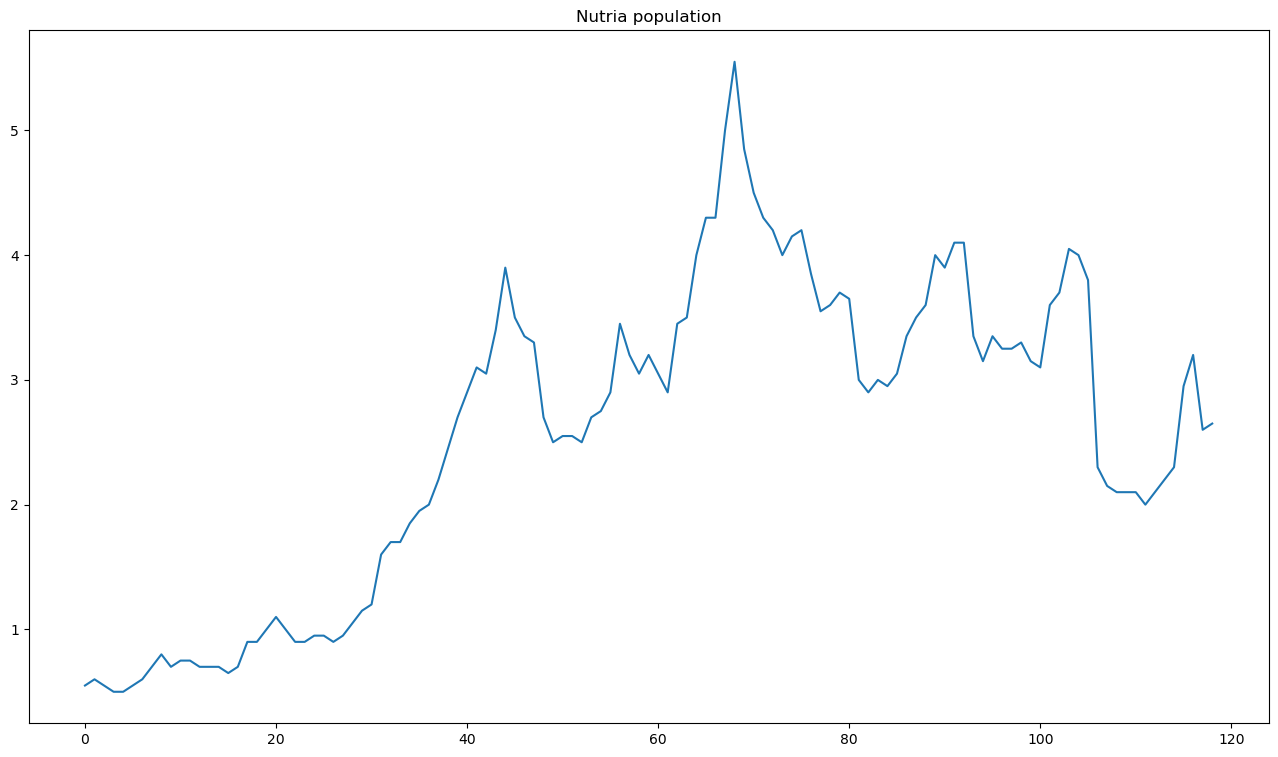

In [1]:
import pandas as pd

data = pd.read_csv("nutria.txt", sep="\t").iloc[:, 0].rename("nutria")

data.plot(figsize=(16, 9), title="Nutria population")

Next, we'll specify the model to use for inference. We'll use the flexible Allee model found [here](https://arxiv.org/pdf/1005.2238.pdf), with the following definition

\begin{align}
    \log N_{t+1} &= \log N_t + a + b N_t + c N^2_t + \sigma_{\epsilon} \cdot \epsilon_{t+1}, \\
    Y_t &= \log N_t + \sigma_{\nu} \nu_t,
\end{align}    

where $\epsilon, \nu$ are two independent Gaussian random variables. We use the same priors as in the paper and get, by translating to code,

In [2]:
from stochproc.timeseries import StateSpaceModel, AffineProcess
import torch
import pyro
from pyro.distributions import InverseGamma, Normal, FoldedDistribution, LogNormal, Uniform


def f(x, a, b, c, sigma_e):
    exped = x.value.exp()
    return x.value + a + b * exped + c * exped ** 2, sigma_e


def obs_dist(x, s):
    return Normal(loc=x.value, scale=s)


def initial_kernel(loc, scale):
    return Normal(loc, scale)


def nutria_model(x):
    a = pyro.sample("a", Normal(loc=0.0, scale=1.0))
    b = pyro.sample("b", Normal(loc=0.0, scale=1.0))
    c = pyro.sample("c", Normal(loc=0.0, scale=1.0))
    
    alpha = x.shape[0] / 2.0
    beta = 2 * (alpha - 1.0) / 10.0                
    sigma_e = pyro.sample("sigma_e", InverseGamma(concentration=alpha, rate=beta))
    
    initial_values = pyro.sample("initial_values", Normal(loc=0.0, scale=1.0))
    inc_dist = Normal(loc=0.0, scale=1.0)
    
    hidden = AffineProcess(f, (a, b, c, sigma_e.sqrt()), inc_dist, initial_kernel, initial_parameters=(initial_values, 0.25))
        
    sigma_n = pyro.sample("sigma_n", InverseGamma(concentration=alpha, rate=beta))
    model = StateSpaceModel(hidden, obs_dist, (sigma_n.sqrt(),))

    model.do_sample_pyro(pyro, obs=x)
    

Next, we'll use MCMC with the NUTS kernel to infer both latent states and parameters

In [3]:
y = torch.from_numpy(data.values).float().log()

nuts_kernel = pyro.infer.NUTS(nutria_model)

mcmc = pyro.infer.MCMC(
    nuts_kernel,
    num_samples=500,
    warmup_steps=300,
    num_chains=1,
)

mcmc.run(y)

Sample: 100%|██████████████████████████████████████████| 800/800 [10:30,  1.27it/s, step size=1.25e-02, acc. prob=0.949]                                                                                                                                                                     


Let's plot the posterior distribution of the parameters.

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'sigma_e'}>,
        <AxesSubplot:title={'center':'sigma_n'}>, <AxesSubplot:>]],
      dtype=object)

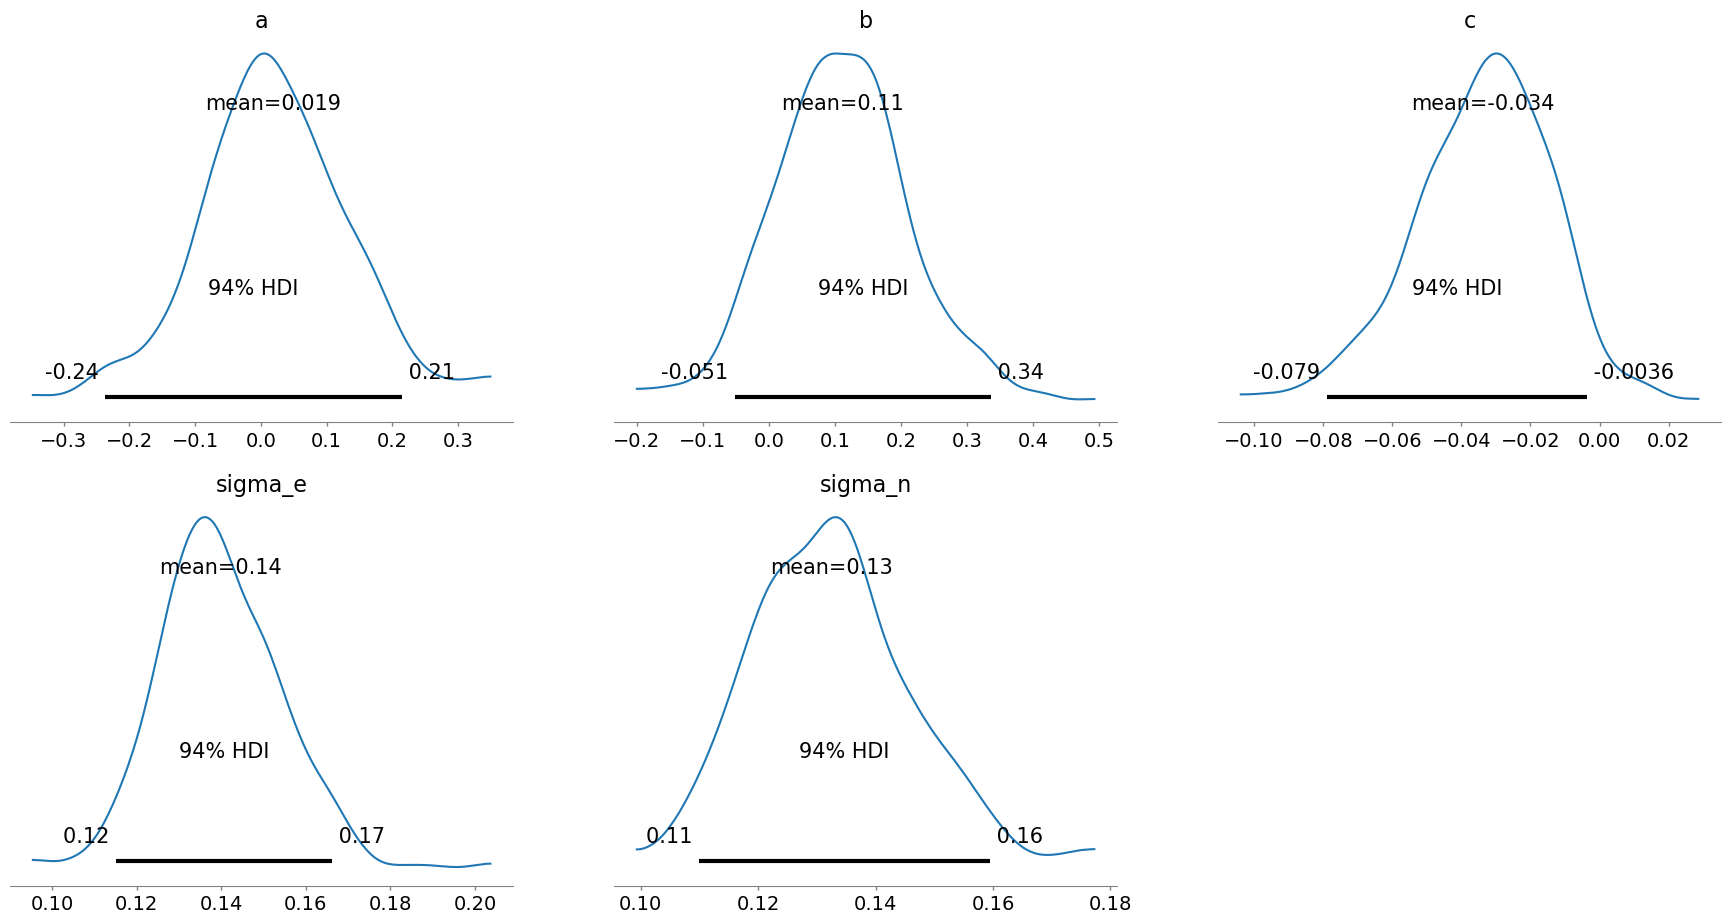

In [4]:
from pyro.infer import Predictive
import arviz
import pandas as pd

num_samples = 1_000

posterior_predictive = Predictive(
    nutria_model,
    posterior_samples=mcmc.get_samples()
)

predictive_draws = {k: v.unsqueeze(0) for k, v in posterior_predictive(y).items()}
posterior_draws = {k: v.unsqueeze(0) for k, v in mcmc.get_samples().items()}

posteriors = arviz.from_dict(posterior_draws)
arviz.plot_posterior(posteriors, var_names=["a", "b", "c", "sigma_e", "sigma_n"])

And finally visualize the inferred distributions of the latent state.

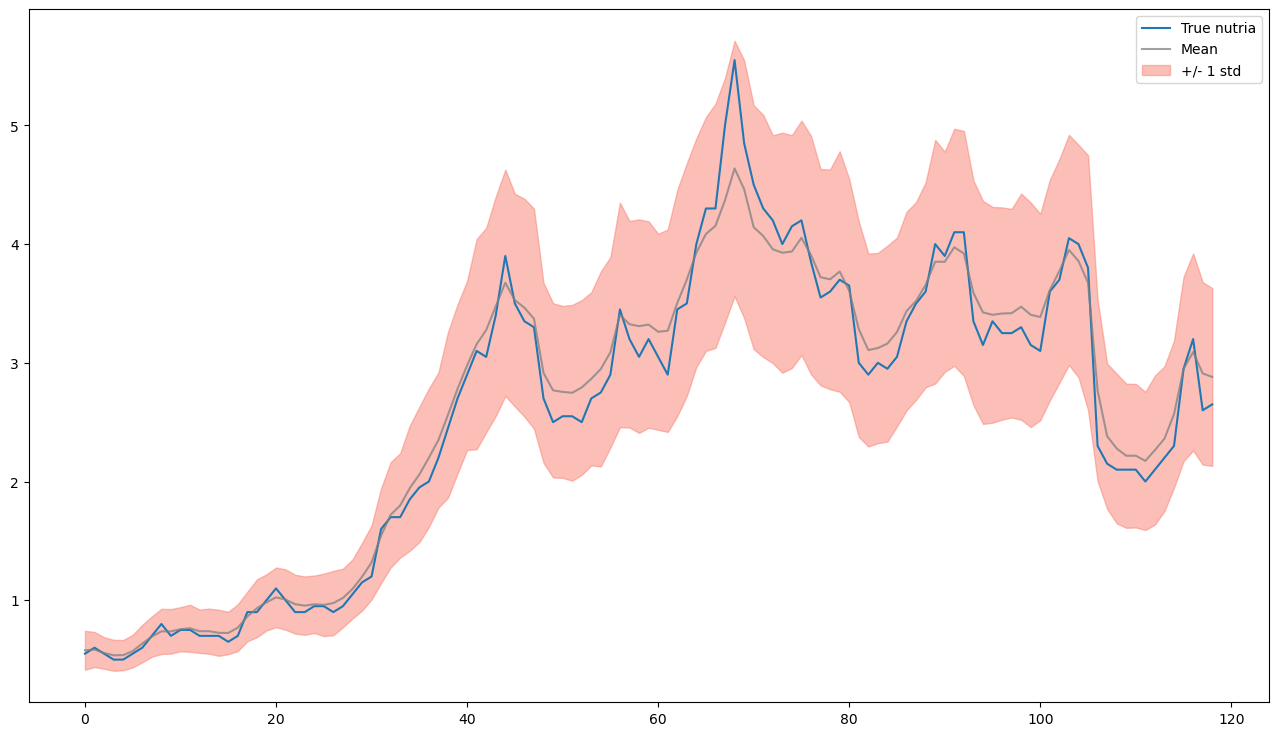

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))

data.plot(ax=ax, label="True nutria")

squeezed = predictive_draws["auxiliary"].squeeze(0).squeeze(-2).exp()

mean = squeezed.mean(0)
std = squeezed.std(0)

high = mean + std
low = mean - std

ax.plot(data.index, mean[1:], color="grey", alpha=0.75, label="Mean")
ax.fill_between(data.index, low[1:], high[1:], alpha=0.5, color="salmon", label="+/- 1 std")

ax.legend()